# Housing Price prediction Part 2 - Linear Models
## Goal:
* Understand overfit, bias, variance, and regularization
* Understand the differences between Ordinary Least Square Linear Regressions, Lasso Regressions, Ridge Regressions
* Perform data split
* Use cross-validation to find best alpha for a Lasso Regression
* Understand model evaluation metrics: R2, MSE, RMSE
* **Self-guide**: the student needs to finish the [homework](https://github.com/brookefzy/pitaya/blob/main/HousingPricePredictor/02b_advanced_feature_engineering.ipynb) for the first day.

## Bias-variance Tradeoff
* Bias (in plain English) - is the difference between the average prediction of our model and the correct value which we are trying to predict. 
* Variance - is the variability of model prediction for a given data point or a value which tells us spread of our data.
<p align="center">
<img src="../asset/overfit_bias.png" alt="overfit_bias" style="width:60%; border:0;">
</p>

Image credit [link](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

## Intro to Linear Models (10 minutes)
Source: https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression
1. Linear models assume a linear relationship between x and y variables
<p align="center">
<img src="../asset/linear_simple.png" alt="linear_simple" style="width:40%; border:0;">
</p>

2. The goal for a linear model then becomes to optimize the weight (b) via the cost function. RSS: residual sum of squares.
<p align="center">
<img src="../asset/linear_cost_function.webp" alt="linear_cost" style="width:40%; border:0;">
</p>

3. Regularization: use \\(  \lambda \\) to avoid overfitting,<br>
Lasso, Ridge, and ElasticNet are part of the Linear Regression family. The main difference among them is whether the model is penalized for its weights.
* Lasso: This is a regularization technique used in feature selection using a Shrinkage method also referred to as the penalized regression method. Lasso is short for **Least Absolute Shrinkage and Selection Operator**, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression.
<p align="center">
<img src="../asset/lasso_cost.webp" alt="lasso_cost" style="width:40%; border:0;">
</p>
* Ridge: Similar to the lasso regression, ridge regression puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square. Ridge regression is also referred to as L2 Regularization. It penalized the extremes of weights.
<p align="center">
<img src="../asset/ridge_cost.webp" alt="ridge_cost" style="width:40%; border:0;">
</p>
<p align="center">
<img src="../asset/lasso_ridge_comp.png" alt="lasso_ridge_comp" style="width:40%; border:0;">
</p>

# Question: what happened if you don't scale your data?

# Tutorials

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## 1. Data Cleaning

In [2]:
# load data
df_train = pd.read_csv('./data/train.csv', index_col='Id')
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Missing data, outliers, categorical vs. numeric values

In [3]:
# we also need to deal with the missing values
def deal_missing(df):
    df['LotFrontage'] = df['LotFrontage'].fillna(0)
    df['Alley'] = df['Alley'].fillna("No Alley Acess")
    df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())
    df['LotFrontage'] = df['LotFrontage'].fillna(0)
    df['BsmtQual'] = df['BsmtQual'].fillna("No Basment")
    df['BsmtCond'] = df['BsmtCond'].fillna("No Basment")
    df['BsmtExposure'] = df['BsmtExposure'].fillna("No Basment")
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna("No Basment")
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna("No Basment")
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['FireplaceQu'] = df['FireplaceQu'].fillna("No Fireplace")
    df['GarageType'] = df['GarageType'].fillna("No Garage")
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['GarageFinish'] = df['GarageFinish'].fillna("No Garage")
    df['GarageQual'] = df['GarageQual'].fillna("No Garage")
    df['GarageCond'] = df['GarageCond'].fillna("No Garage")
    df['Fence'] = df['Fence'].fillna("No Fence")
    df['MiscFeature'] = df['MiscFeature'].fillna("No Miscellaneous Feature")
    return df

def remove_outlier(df):
    # only remove the outliers if the feature is numeric
    for x in df.columns:
        if df[x].dtype != 'object':
            df[f'{x}_zscore'] = zscore(df[f'{x}'])
            df.drop(df[(df[f'{x}_zscore'] >= 3) | (df[f'{x}_zscore'] <= -3)].index, inplace=True)
            df.drop(columns=[f'{x}_zscore'], inplace=True)
    return df
    

In [4]:
# based on previous analysis, we will drop the following columns
df_train.drop(columns=['MasVnrType','PoolQC','PoolArea','BsmtHalfBath','KitchenAbvGr','Utilities'],inplace=True)
df_train = deal_missing(df_train)
df_train = remove_outlier(df_train)
print(df_train.shape)

(1001, 74)


In [5]:
categorical_features = df_train.select_dtypes(include=['object']).columns
numerical_features = df_train.select_dtypes(exclude=['object']).columns
print(f'categorical_features: {categorical_features}')
print(f'numerical_features: {numerical_features}')
# there are numericl features are encoded categorical features, we need to convert them to categorical features
cat_add = ['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']
non_feature = ['SalePrice']
categorical_features = categorical_features.append(pd.Index(cat_add))
numerical_features = numerical_features.drop(pd.Index(cat_add))
print(f'categorical_features revised: {categorical_features}')
print(f'numerical_features revised: {numerical_features}')

categorical_features: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
numerical_features: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Firepla

In [6]:
MSSubClassMap ={20 : '1-STORY 1946 & NEWER ALL STYLES',
               30 : '1-STORY 1945 & OLDER',
               40 : '1-STORY W/FINISHED ATTIC ALL AGES',
               45 : "1-1/2 STORY - UNFINISHED ALL AGES",
                50 : "1-1/2 STORY FINISHED ALL AGES",
                60 : "2-STORY 1946 & NEWER",
                70 : "2-STORY 1945 & OLDER",
                75 : "2-1/2 STORY ALL AGES",
                80 : "SPLIT OR MULTI-LEVEL",
                85 : "SPLIT FOYER",
                90 : "DUPLEX - ALL STYLES AND AGES",
               120 : "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
               150 : "1-1/2 STORY PUD - ALL AGES",
               160 : "2-STORY PUD - 1946 & NEWER",
               180 : "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
               190 : "2 FAMILY CONVERSION - ALL STYLES AND AGES"}
MSZoningMap={
    "A" : "Agriculture",
       "C (all)" : "Commercial",
       "FV" : "Floating Village Residential",
       "I" : "Industrial",
       "RH" : "Residential High Density",
       "RL" : "Residential Low Density",
       "RP" : "Residential Low Density Park", 
       "RM" : "Residential Medium Density"
}

# df_train['MSSubClass'] = df_train['MSSubClass'].map(MSSubClassMap)
for x in cat_add:
    df_train[x] = df_train[x].astype(str)

### Data Encoding

In [7]:
df_train = pd.get_dummies(df_train,
                          dtype=float,
                          drop_first=True,
                          # drop the first column to avoid multicollinearity
                          )

In [8]:
df_train.shape

(1001, 503)

In [1]:
# df_train.to_csv('./data/train_clean.csv') # optional: save the file for later usage

## Data Split
* Typically split data by train and test

In [9]:
X = df_train.drop(columns=non_feature)
y = df_train['SalePrice'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=111
    ) 

## Data standardization

In [10]:
X_train_nstd = X_train.copy()
X_test_nstd = X_test.copy()
y_train_nstd = y_train.copy()

# standardize the data
xscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

yscaler = StandardScaler()
y_train = yscaler.fit_transform(y_train.reshape(-1,1)).flatten()

## Run the linear model and understand their performance
* Understand the evaluation metrics: R2, MSE, RMSE, MAE
* R-Squared (R²):  - measures the proportion of the total variation in the dependent variable that is captured by the model.
$$R^2 = 1 - (SSR/SST)$$
 a. SSR (Sum of Squared Residuals) is the sum of the squares of the residuals. The residuals are the difference between the actual values of the dependent variable and the predicted values from the regression model.
 
 b. SST (Total Sum of Squares) is the total sum of squares, which is the sum of the differences between the actual values of the dependent variable and the mean value of the dependent variable, all squared.
* Mean Squared Error (MSE): This is the average of the squared differences between the predicted and actual values. It gives more weight to larger differences and is particularly useful when we have unexpected values that we want to take into account.
$$MSE = 1/n \times \sum_{i=1}^n(Y_i - \hat{Y_i})^2$$

* Root Mean Squared Error (RMSE): This is the square root of the MSE. By square rooting the MSE, we return the error metric to the same unit as the target variable, which can often make it easier to interpret. (The goal is to minimize large errors)

* Mean Absolute Error (MAE): This is the average of the absolute differences between the predicted and actual values. Unlike MSE, it treats all differences equally and is less sensitive to outliers.
$$MAE = 1/n \times \sum_{i=1}^n|Y_i - \hat{Y_i}|$$

In [11]:
lr = LinearRegression()
lr.fit(X_train_nstd, y_train_nstd)

lasso = Lasso(alpha=0.001) # what is alpha? https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
lasso.fit(X_train,y_train)

ridge = Ridge()
ridge.fit(X_train,y_train)

# store the model for analysis
model_dict = {
    'lr':lr,
    'lasso':lasso,
    'ridge':ridge
}
test_pred = {}
train_pred = {}
test_result = {}
train_result = {}

Linear Regression R2 Score: 0.5566786201300329
Linear Regression RMSE: 40644.716046880785


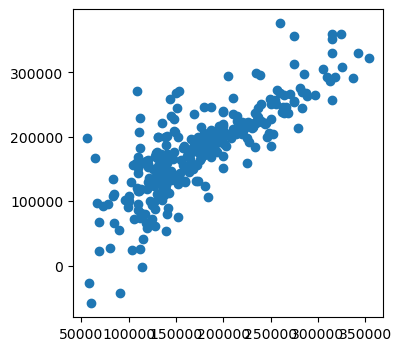

In [12]:
# check the linear first
sel = 'lr'
model = model_dict[sel]
y_train_pred = model.predict(X_train_nstd)
y_pred = model.predict(X_test_nstd)
train_pred[sel] = y_train_pred
test_pred[sel] = y_pred
# plot the result
plt.figure(figsize=(4,4))
plt.scatter(y_test,y_pred)
# get the r2 score and RMSE
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Linear Regression R2 Score: {r2}')
print(f'Linear Regression RMSE: {rmse}')

test_result[sel] = [r2,rmse]
train_result[sel] = [r2_score(y_train_nstd, y_train_pred),
                     math.sqrt(mean_squared_error(y_train_nstd, y_train_pred))]


In [13]:
# predict the test data

for model in list(model_dict.keys())[1:]:
    print(f"Start training - {model}")
    y_pred = model_dict[model].predict(X_train)
    # y_pred = scaler.inverse_transform(y_pred)
    r2 = r2_score(y_train,y_pred)
    rmse = math.sqrt(mean_squared_error(y_train,y_pred))
    print(f'{model} train r2_score: {r2}')
    print(f'{model} train rmse: {rmse}')
    
    train_pred[model] = y_pred
    train_result[model] = [r2, rmse]
    
    print(f"Start testing - {model}")
    y_pred = model_dict[model].predict(X_test)
    y_pred = yscaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    
    r2 = r2_score(y_test,y_pred)
    rmse = math.sqrt(mean_squared_error(y_test,y_pred))
    print(f'{model} test r2_score: {r2}')
    print(f'{model} test rmse: {rmse}')
    test_pred[model] = y_pred
    test_result[model] = [r2, rmse]

Start training - lasso
lasso train r2_score: 0.9667704569380016
lasso train rmse: 0.18228972286445128
Start testing - lasso
lasso test r2_score: 0.8843718265622809
lasso test rmse: 20757.573685180138
Start training - ridge
ridge train r2_score: 0.9734198639728671
ridge train rmse: 0.16303415601380247
Start testing - ridge
ridge test r2_score: 0.7676480478027573
ridge test rmse: 29425.098039592456


In [14]:
# combine the train test result into one dataframe
train_result_df = pd.DataFrame(train_result)
train_result_df.index = ['r2_score','rmse']

train_result_df['data'] = 'train'
test_result_df = pd.DataFrame(test_result)
test_result_df.index = ['r2_score','rmse']

test_result_df['data'] = 'test'
result_df = pd.concat([train_result_df,test_result_df])\
    .reset_index()\
        .pivot(columns = 'index',index='data',values=['lr','lasso','ridge'])
result_df
# explain the results. Is this good? bad? why? Which one is the best model so far? why?

lr                   lasso                   ridge              
index  r2_score          rmse  r2_score          rmse  r2_score          rmse
data                                                                         
test   0.556679  40644.716047  0.884372  20757.573685  0.767648  29425.098040
train  0.974618   8851.714744  0.966770      0.182290  0.973420      0.163034

## 5-fold cross-validation
* What is K-fold cross validation? [Source](https://towardsdatascience.com/what-is-k-fold-cross-validation-5a7bb241d82f)
<p align="center">
<img src="../asset/five_fold_cross.webp" alt="5-fold" style="width:60%; border:0;">
</p>

* Lasso linear model with iterative fitting along a regularization path:[LINK](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
* **cv** (int), cross-validation generator or iterable, default=None

In [176]:
# use lassoCV to find the best alpha
from sklearn.linear_model import LassoCV, RidgeCV
# repeat the analysis
# in this process, we initiate a series of different random state
# and then we will train the model and get the average result
statels = [i for i in range(5,50, 5)]
statels

[5, 10, 15, 20, 25, 30, 35, 40, 45]

In [149]:
def split_data(X,y,random_state):
    # random split with the seed frozen
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state) 
    # standardize the data
    xscaler = StandardScaler()
    X_train = xscaler.fit_transform(X_train)
    X_test = xscaler.transform(X_test)
    yscaler = StandardScaler()
    y_train = yscaler.fit_transform(y_train.reshape(-1,1)).flatten()
    return X_train, X_test, y_train, y_test

def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    predictions = yscaler.inverse_transform(predictions.reshape(-1,1)).flatten()
    predictions_train = model.predict(X_train)
    r2_train = r2_score(y_train, predictions_train)
    rmse_train = math.sqrt(mean_squared_error(y_train, predictions_train))
    
    r2 = r2_score(y_test, predictions)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    
    return r2_train, rmse_train, r2, rmse


In [177]:
from tqdm import tqdm
new_train_result = {}
new_test_result = {}
train_result = []
for state in tqdm(statels):
    X_train, X_test, y_train, y_test = split_data(X,y,state)
    model = LassoCV(cv=5, random_state=state)
    r2_train, rmse_train, r2, rmse = train_model(model, X_train, y_train, X_test, y_test)
    train_result.append([r2_train, r2, rmse_train, rmse])

100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


In [185]:
# plot the result
train_result_lasso = pd.DataFrame(train_result, columns=['r2_train','r2_test','rmse_train','rmse_test'])
train_result_lasso
newdf = train_result_lasso.mean()
newdf

r2_train          0.945568
r2_test           0.891859
rmse_train        0.232760
rmse_test     18368.308984
dtype: float64

In [187]:
previous = pd.concat([train_result_df,test_result_df])
previous['lassoCV'] = [
    newdf.loc['r2_train'],
    
    newdf.loc['rmse_train'],
    newdf.loc['r2_test'],
    newdf.loc['rmse_test']
]
previous

,lr,lasso,ridge,data,lassoCV
r2_score,0.974618,0.966770,0.973420,train,0.945568
rmse,8851.714744,0.182290,0.163034,train,0.232760
r2_score,0.556679,0.884372,0.767648,test,0.891859
rmse,40644.716047,20757.573685,29425.098040,test,18368.308984


In [188]:
finalresult = previous.reset_index()\
        .pivot(columns = 'index',index='data',values=['lr','lasso','ridge','lassoCV'])
finalresult

lr                   lasso                   ridge                \
index  r2_score          rmse  r2_score          rmse  r2_score          rmse   
data                                                                            
test   0.556679  40644.716047  0.884372  20757.573685  0.767648  29425.098040   
train  0.974618   8851.714744  0.966770      0.182290  0.973420      0.163034   

        lassoCV                
index  r2_score          rmse  
data                           
test   0.891859  18368.308984  
train  0.945568      0.232760

In [ ]:
SVM:

In [ ]:
m-fold

# Course Work today: 
* Further using any other techniques to transform the data
* Use 02b_advanced_feature_engineer.ipynb to produce a cleaned dataset for further usage.
* Annotate the 02b_advanced_feature_engineer.ipynb to make sure you understand all codes